100%|██████████| 26.4M/26.4M [00:02<00:00, 12.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.96MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.5MB/s]
epoch:: 100%|██████████| 200/200 [09:09<00:00,  2.75s/it, loss=0.06797069311141968]


Error de test: 0.06857138970822704


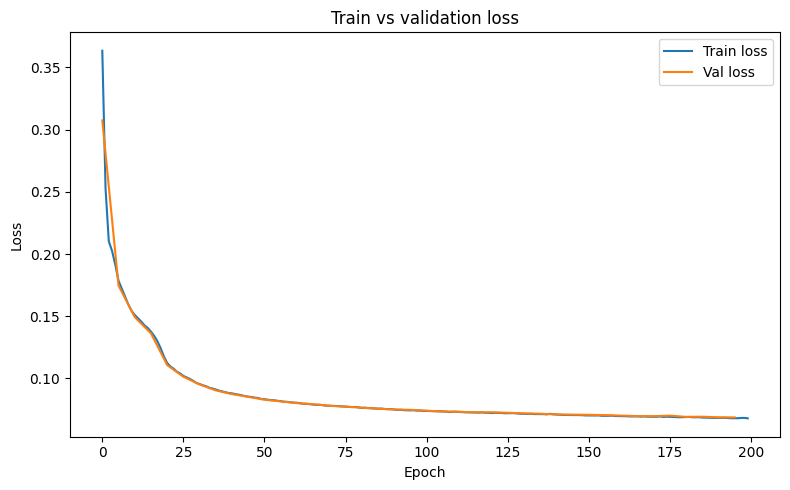

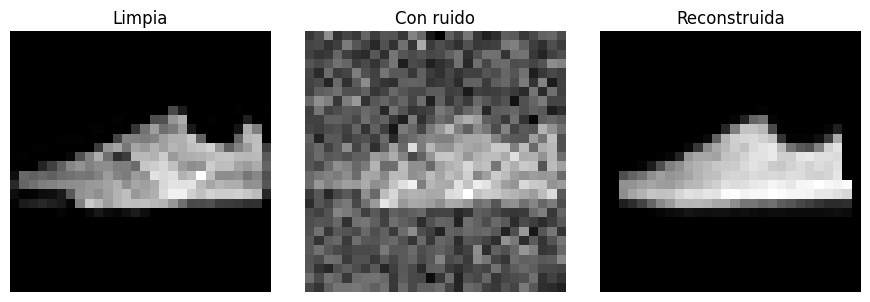

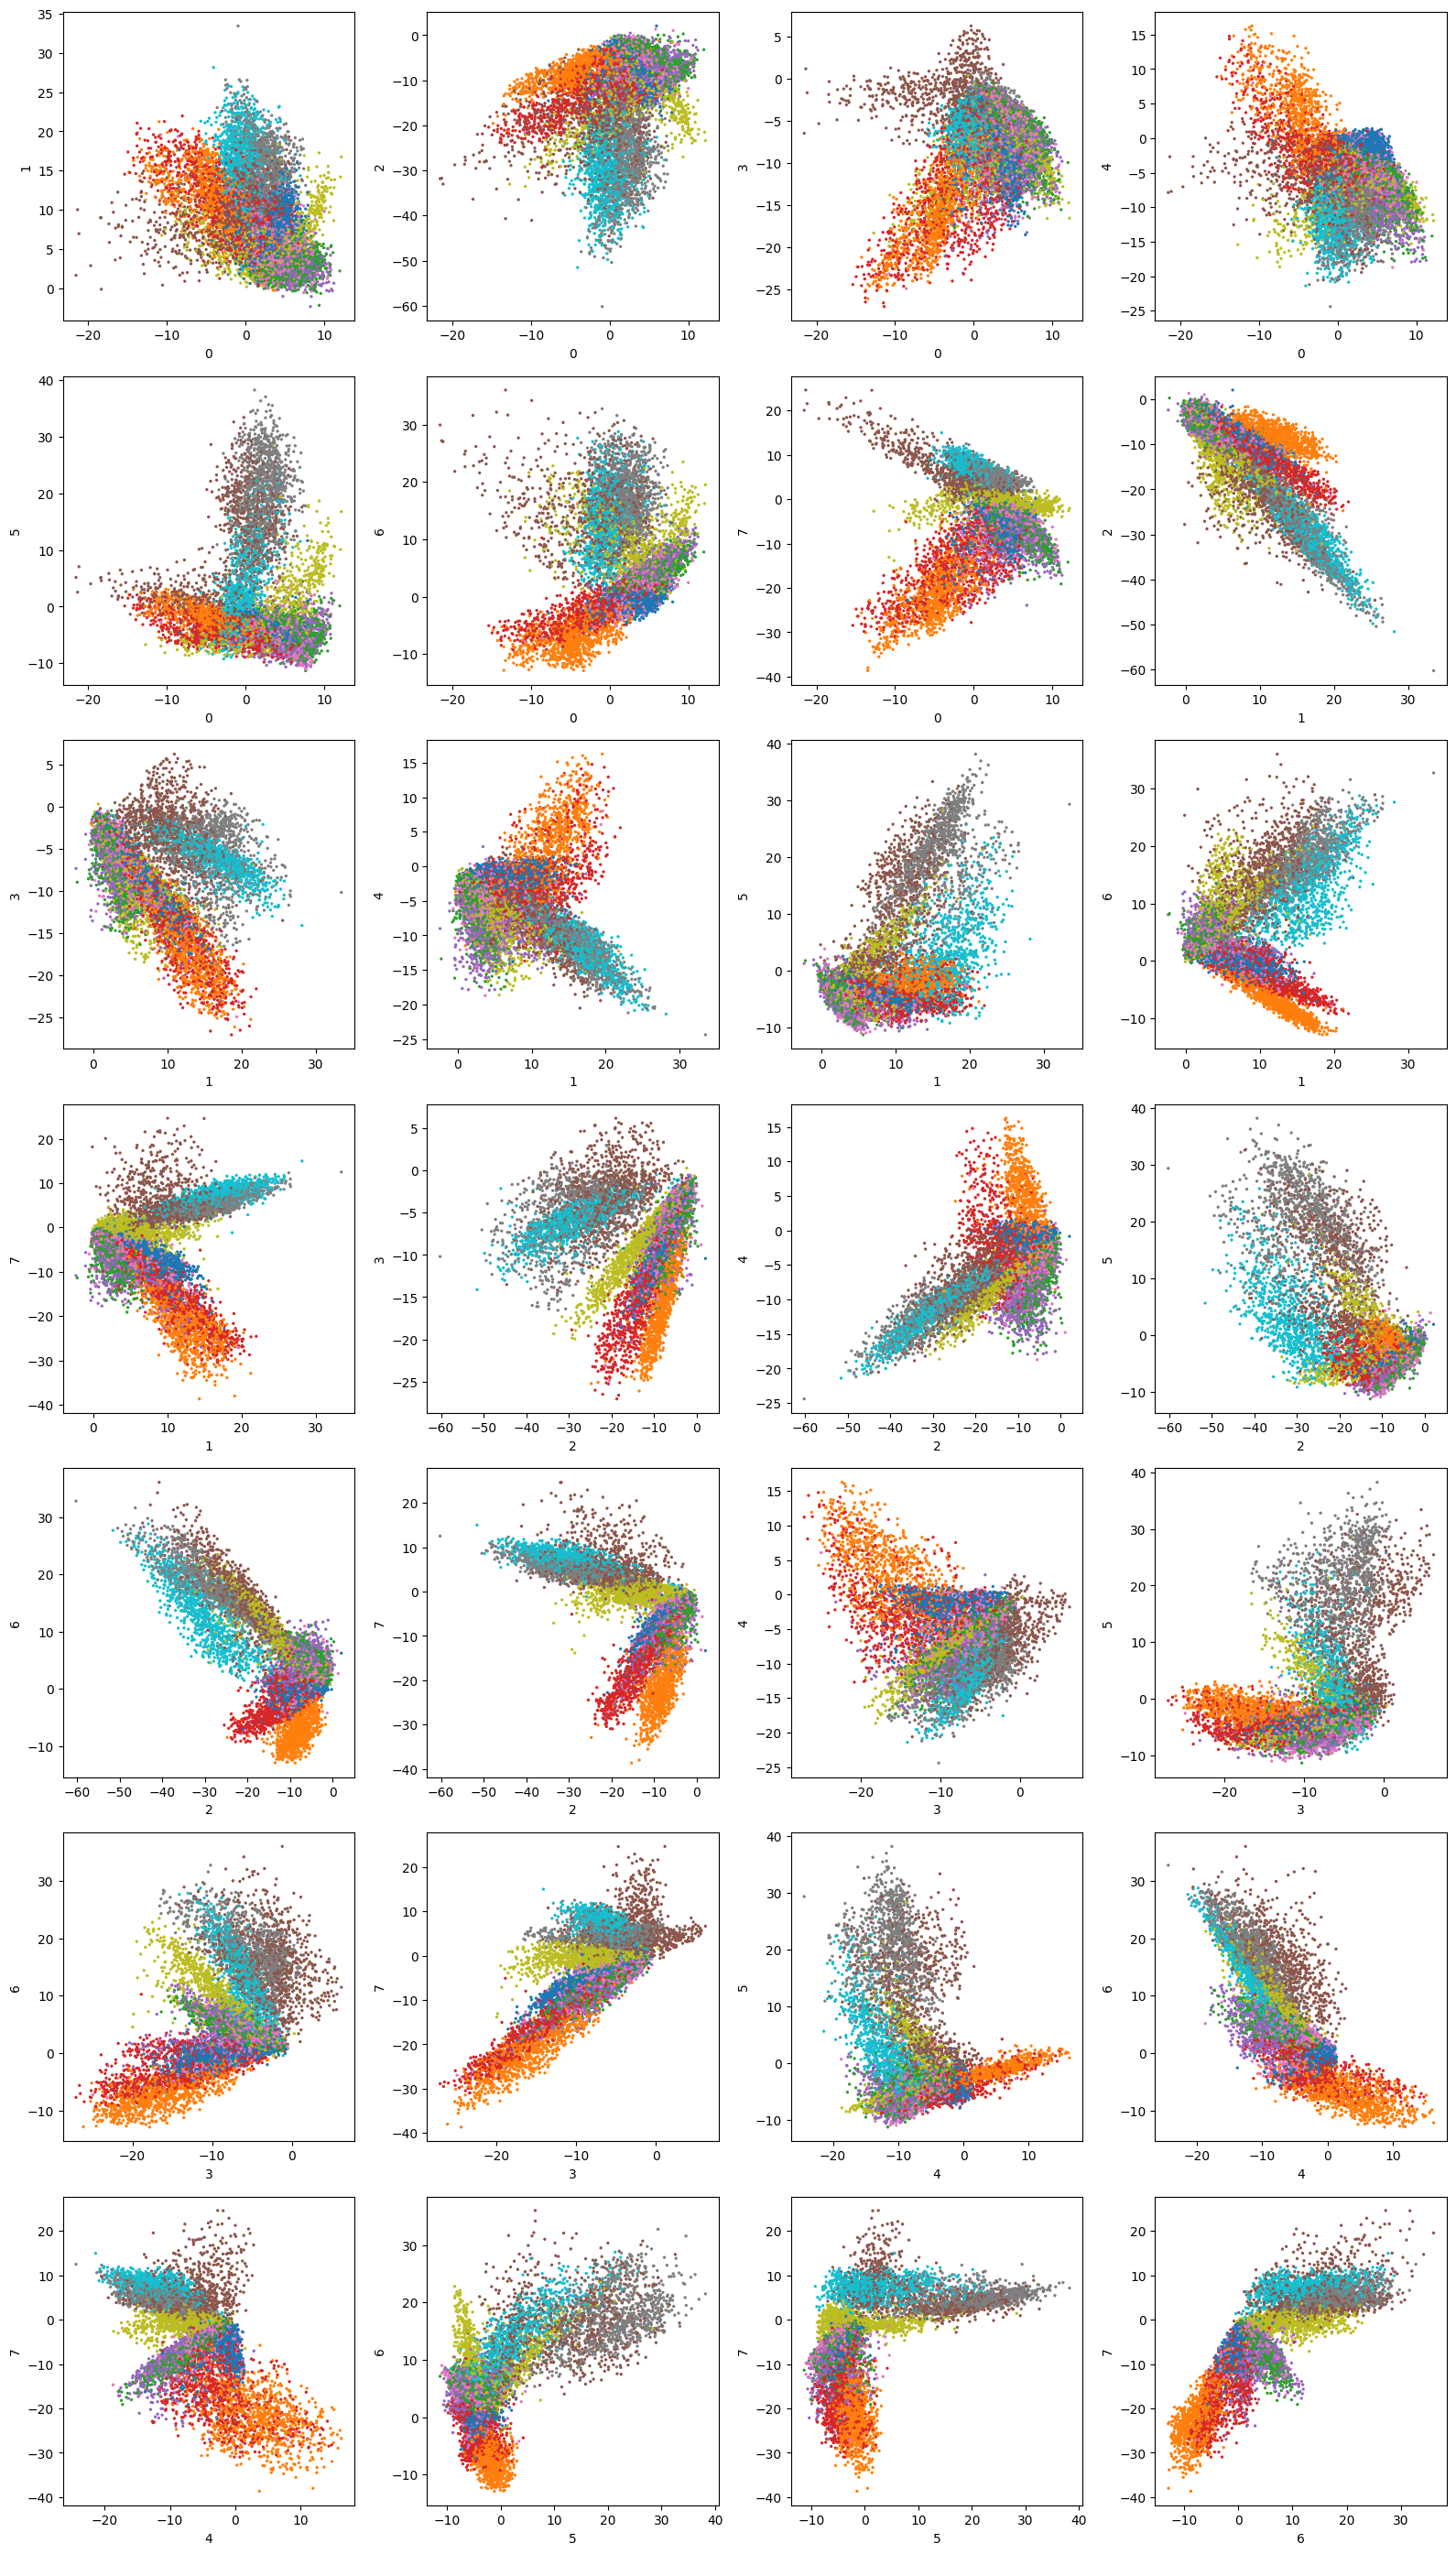

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
import math

workpath = './data'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class CudaDataset(Dataset):
    def __init__(self, dataset, device, sigma=0, mu=0, devolver_limpio=False):
        self.dataset = dataset
        self.cuda_y = []
        self.cuda_x = []
        self.device = device
        self.sigma = sigma
        self.mu = mu
        self.devolver_limpio = devolver_limpio
        for x, y in tqdm(self.dataset, desc="Moving to GPU"):
            self.cuda_x.append(x.to(self.device))
            self.cuda_y.append(torch.tensor(y, device=self.device))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x_clean = self.cuda_x[idx]
        if self.sigma > 0:
            noise = torch.randn_like(x_clean) * self.sigma + self.mu
            x_noisy = x_clean + noise
        else:
            x_noisy = x_clean
        if self.devolver_limpio:
            return x_noisy, x_clean, self.cuda_y[idx]
        else:
            return x_noisy, self.cuda_y[idx]

class Early_Stop():
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_val_loss = None
        self.no_val_improvement_times = 0
        self.stop = False

    def check_stop(self, val_loss):
        if self.best_val_loss is None or (val_loss + self.delta) < self.best_val_loss:
            self.best_val_loss = val_loss
            self.no_val_improvement_times = 0
        else:
            self.no_val_improvement_times += 1
            self.stop = self.no_val_improvement_times >= self.patience

class DenoisingAutoencoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        recon = recon.view(-1, 1, 28, 28)
        return recon, z

def learning_loop_autoencoder_with_early_stopping(train_dataloader, val_dataloader, model, epochs, loss_fn, learning_rate, optimizer, validation_freq, early_stop):
    epoch_loss_list = []
    val_loss_list = []
    opt = optimizer(model.parameters(), lr=learning_rate)
    with tqdm(range(epochs), desc="epoch:") as pbar:
        for epoch in pbar:
            steps_loss_list = []
            for x_noisy, x_clean, _ in train_dataloader:
                recon, _ = model(x_noisy)
                opt.zero_grad()
                loss = loss_fn(recon, x_clean)
                loss.backward()
                steps_loss_list.append(loss.clone().detach())
                opt.step()
            train_loss = torch.stack(steps_loss_list).mean()
            epoch_loss_list.append(train_loss)
            pbar.set_postfix(loss=f"{train_loss}")
            if epoch % validation_freq == 0:
                val_step_loss_list = []
                with torch.no_grad():
                    for x_val_noisy, x_val_clean, _ in val_dataloader:
                        recon_val, _ = model(x_val_noisy)
                        loss_val = loss_fn(recon_val, x_val_clean)
                        val_step_loss_list.append(loss_val.detach())
                val_loss = torch.stack(val_step_loss_list).mean()
                val_loss_list.append(val_loss)
                early_stop.check_stop(val_loss)
                model.train()
                if early_stop.stop:
                    break
    return model, epoch_loss_list, val_loss_list

data_size = [50000, 10000]

base_train_dataset = datasets.FashionMNIST(
    root=workpath,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

full_train_dataset = CudaDataset(
    base_train_dataset,
    device,
    sigma=0.2,
    mu=0.0,
    devolver_limpio=True
)

train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, data_size)

base_test_dataset = datasets.FashionMNIST(
    root=workpath,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

test_dataset = CudaDataset(
    base_test_dataset,
    device,
    sigma=0.2,
    mu=0.0,
    devolver_limpio=True
)

batch_size = 4096
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

learning_rate = 1e-3
epochs = 200
validation_freq = 5
delta = 1e-3
patience = 25
early_stop = Early_Stop(patience=patience, delta=delta)
optimizer_cls = torch.optim.Adam
loss_fn = torch.nn.L1Loss()

model = DenoisingAutoencoder(latent_dim=8).to(device)

model, train_loss_list, val_loss_list = learning_loop_autoencoder_with_early_stopping(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    learning_rate,
    optimizer_cls,
    validation_freq=validation_freq,
    early_stop=early_stop
)

test_mae_sum = 0.0
n_pixels_total = 0
with torch.no_grad():
    for x_noisy, x_clean, _ in test_dataloader:
        recon, _ = model(x_noisy)
        batch_mae = torch.sum(torch.abs(recon - x_clean))
        test_mae_sum += batch_mae.item()
        n_pixels_total += x_clean.numel()

test_mae = test_mae_sum / n_pixels_total
print(f"Error de test: {test_mae}")

train_loss_values = [l.item() for l in train_loss_list]
val_loss_values = [l.item() for l in val_loss_list]

plt.figure(figsize=(8, 5))
plt.plot(train_loss_values, label="Train loss")

val_x = list(range(0, len(train_loss_values), validation_freq))[:len(val_loss_values)]
plt.plot(val_x, val_loss_values, label="Val loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train vs validation loss")
plt.tight_layout()
plt.show()



with torch.no_grad():
    x_noisy_batch, x_clean_batch, y_batch = next(iter(test_dataloader))
    recon_batch, _ = model(x_noisy_batch)

idx = 0
x_clean_ex = x_clean_batch[idx].detach().cpu().squeeze().numpy()
x_noisy_ex = x_noisy_batch[idx].detach().cpu().squeeze().numpy()
recon_ex = recon_batch[idx].detach().cpu().squeeze().numpy()

plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.imshow(x_clean_ex, cmap='gray')
plt.title("Limpia")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(x_noisy_ex, cmap='gray')
plt.title("Con ruido")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(recon_ex, cmap='gray')
plt.title("Reconstruida")
plt.axis('off')
plt.tight_layout()
plt.show()


all_z = []
all_y = []
with torch.no_grad():
    for x_noisy, _, y in test_dataloader:
        _, z = model(x_noisy)
        all_z.append(z.detach().cpu())
        all_y.append(y.detach().cpu())

all_z = torch.cat(all_z, dim=0)
all_y = torch.cat(all_y, dim=0)

all_z_np = all_z.numpy()
all_y_np = all_y.numpy()

pairs = [(i, j) for i in range(8) for j in range(i + 1, 8)]

n_pairs = len(pairs)
cols = 4
rows = math.ceil(n_pairs / cols)

plt.figure(figsize=(4 * cols, 4 * rows))
for i, (a, b) in enumerate(pairs, 1):
    plt.subplot(rows, cols, i)
    plt.scatter(all_z_np[:, a], all_z_np[:, b], c=all_y_np, cmap='tab10', s=2)
    plt.xlabel(f"{a}")
    plt.ylabel(f"{b}")
plt.tight_layout()
plt.show()



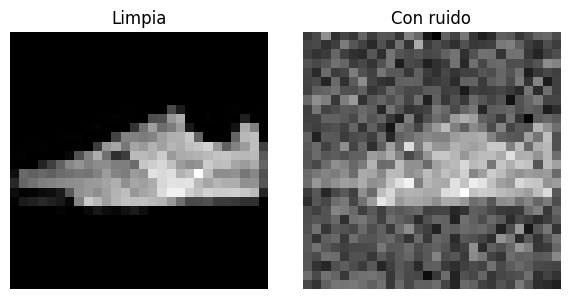

In [2]:
# Mostrar de nuevo EXACTAMENTE la misma imagen limpia y con ruido
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.title("Limpia")
plt.imshow(x_clean_ex, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Con ruido")
plt.imshow(x_noisy_ex, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
